SCARlink requires scRNA-seq normalized relative counts in a [Seurat](https://satijalab.org/seurat/index.html) object and the corresponding multiomic scATAC-seq with non-binarized tile matrix in [ArchR](https://www.archrproject.com/index.html) object. The cell names should be in the same format in both the objects. The ArchR object needs to contain the TileMatrix with 500bp tiles. This R notebook demonstrates how the scRNA-seq and scATAC-seq objects need to be processed in order to run SCARlink. Here we use previously processed PBMC multiomic data from 10x Genomics.

In [2]:
library(Seurat)
library(ArchR)

Download example Seurat (scRNA-seq) and ArchR (scATAC-seq) objects of PBMC multi-ome.

In [3]:
system("wget https://zenodo.org/records/10899754/files/pbmc_test_input.zip -O ./pbmc_test_input.zip;
        unzip ./pbmc_test_input.zip")

In [4]:
scrna.file <- "pbmc_test_input/pbmc_scrna_test.rds"
scatac.file <- "pbmc_test_input/pbmc_scatac_test"

In [5]:
scrna.object <- readRDS(scrna.file)
scatac.object <- loadArchRProject(scatac.file)

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

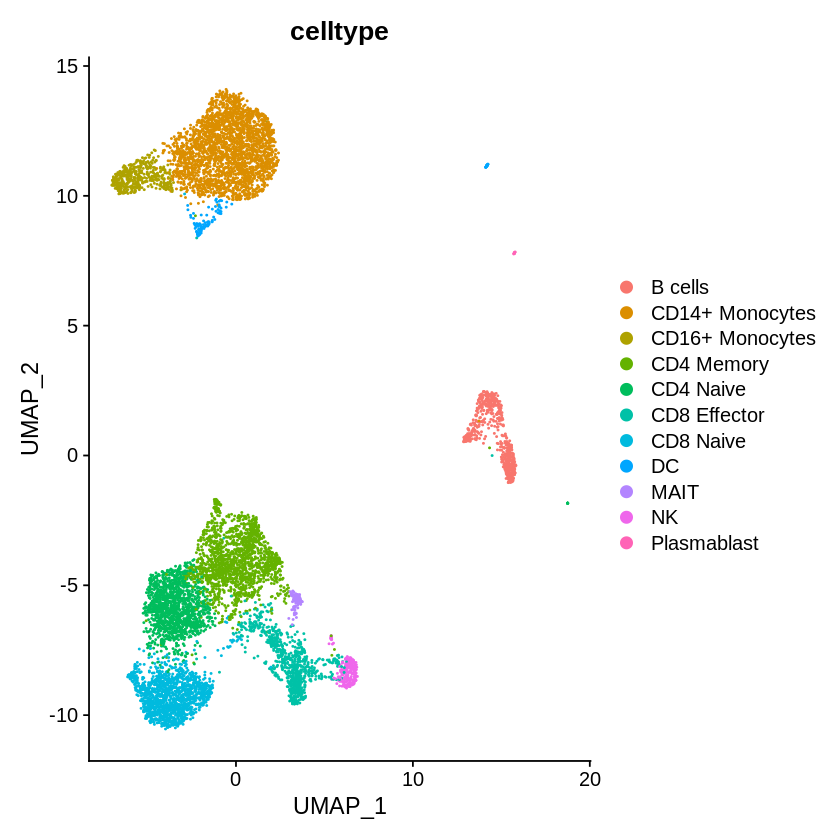

In [6]:
# Plot to check the cell type clusters
DimPlot(scrna.object, group.by="celltype")

### Check if cell names are in the same format in both `scrna.object` and `scatac.object`. If not, update the names to be in the same format.

In [7]:
## cell names in scrna.object

# head(colnames(scrna.object))

# Example output:
# 'pbmc_AAACAGCCAAGGAATC-1' 'pbmc_AAACAGCCAATCCCTT-1' 'pbmc_AAACAGCCAATGCGCT-1'
# 'pbmc_AAACAGCCACCAACCG-1' 'pbmc_AAACAGCCAGGATAAC-1' 'pbmc_AAACAGCCAGTAGGTG-1'

In [8]:
## cell names in scatac.object

# head(scatac.object$cellNames)

# Example output: 
# 'pbmc#AAACAGCCAAGGAATC-1' 'pbmc#AAACAGCCAATCCCTT-1' 'pbmc#AAACAGCCAATGCGCT-1' 
# 'pbmc#AAACAGCCACCAACCG-1' 'pbmc#AAACAGCCAGGATAAC-1' 'pbmc#AAACAGCCAGTAGGTG-1'

##### Update cell names in scrna.object to match the cell names in scatac.object

In [9]:
# scrna.object <- RenameCells(scrna.object, new.names=gsub("_", "#", colnames(scrna.object)))

In [10]:
# new cell names in scrna.object match the format of cell names in scatac.object
head(colnames(scrna.object))

head(scatac.object$cellNames)

[1] "pbmc#AAACAGCCAAGGAATC-1" "pbmc#AAACAGCCAATCCCTT-1"
[3] "pbmc#AAACAGCCAATGCGCT-1" "pbmc#AAACAGCCACCAACCG-1"
[5] "pbmc#AAACAGCCAGGATAAC-1" "pbmc#AAACAGCCAGTAGGTG-1"

[1] "pbmc#AAACAGCCAAGGAATC-1" "pbmc#AAACAGCCAATCCCTT-1"
[3] "pbmc#AAACAGCCAATGCGCT-1" "pbmc#AAACAGCCACCAACCG-1"
[5] "pbmc#AAACAGCCAGGATAAC-1" "pbmc#AAACAGCCAGTAGGTG-1"

### Relative counts normalization scRNA-seq count matrix

The normalization step can be skipped. SCARlink will do the normalization. The data is normalized to counts per 10k or counts per median. See [wiki](https://github.com/snehamitra/SCARlink/wiki/2.-SCARlink-preprocessing) for more details.

In [11]:
scrna.object <- NormalizeData(scrna.object, normalization.method = "RC")

In [12]:
## save object
# saveRDS(scrna.object, file = scrna.file)

### Check if scatac.object has non-binarized tile matrix. If not, then add tile matrix.

In [13]:
getAvailableMatrices(ArchRProj = scatac.object)

[1] "TileMatrix"

Here `scatac.object` already has the TileMatrix. Otherwise, it could have been generated using [`addTileMatrix(input=scatac.object, tileSize = 500, binarize=FALSE)`](https://www.archrproject.com/reference/addTileMatrix.html).

#### Check if available TileMatrix is binarized

If the ArchR object contains a binarized tile matrix then `getMatrixFromProject` will throw an error when trying to read a binarized matrix as a non-binarized matrix:

```

> tm <- getMatrixFromProject(
  ArchRProj = scatac.object,
  useMatrix = 'TileMatrix',
  binarize = FALSE)
  
Error in .getMatFromArrow(ArrowFile = ArrowFile, featureDF = featureDF, : Sparse Matrix in Arrow is Binarized! Set binarize = TRUE to use matrix!
Traceback:

1. getMatrixFromProject(ArchRProj = scatac.object, useMatrix = "TileMatrix", 
 .     binarize = FALSE)
2. .safelapply(seq_along(ArrowFiles), function(x) {
 .     .logDiffTime(paste0("Reading ", useMatrix, " : ", names(ArrowFiles)[x], 
 .         "(", x, " of ", length(ArrowFiles), ")"), t1 = tstart, 
 .         verbose = FALSE, logFile = logFile)
 .     allCells <- .availableCells(ArrowFile = ArrowFiles[x], subGroup = useMatrix)
 .     allCells <- allCells[allCells %in% cellNames]
 .     if (length(allCells) != 0) {
 .         o <- getMatrixFromArrow(ArrowFile = ArrowFiles[x], useMatrix = useMatrix, 
 .             useSeqnames = useSeqnames, cellNames = allCells, 
 .             ArchRProj = ArchRProj, verbose = FALSE, binarize = binarize, 
 .             logFile = logFile)
 .         .logDiffTime(paste0("Completed ", useMatrix, " : ", names(ArrowFiles)[x], 
 .             "(", x, " of ", length(ArrowFiles), ")"), t1 = tstart, 
 .             verbose = FALSE, logFile = logFile)
 .         o
 .     }
 .     else {
 .         NULL
 .     }
 . }, threads = threads)
3. lapply(...)
4. FUN(X[[i]], ...)
5. getMatrixFromArrow(ArrowFile = ArrowFiles[x], useMatrix = useMatrix, 
 .     useSeqnames = useSeqnames, cellNames = allCells, ArchRProj = ArchRProj, 
 .     verbose = FALSE, binarize = binarize, logFile = logFile)
6. .getMatFromArrow(ArrowFile = ArrowFile, featureDF = featureDF, 
 .     cellNames = cellNames, useMatrix = useMatrix, binarize = binarize, 
 .     useIndex = FALSE)
7. stop("Sparse Matrix in Arrow is Binarized! Set binarize = TRUE to use matrix!")
```

#### Recompute TileMatrix if the TileMatrix is not binarized

```
> scatac.object <- addTileMatrix(input=scatac.object, binarize=FALSE, tileSize = 500, force=TRUE)
```

In [ ]:
# check if tile matrix is not binarized -- runs without errors
tm <- getMatrixFromProject(
  ArchRProj = scatac.object,
  useMatrix = 'TileMatrix',
  binarize = FALSE)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-19b116ed420b-Date-2024-03-30_Time-21-21-45.log
If there is an issue, please report to github with logFile!

